In [2]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

|종목 수|시가총액 하위(%)|기간|리밸런싱|누적수익률(배)|CAGRR|IFRS|CFS|NOTE|
|-----|-------|-------|-----|-----|----|---|-|-|
| 30 | 20 | 2002 ~ 2016 |8/1| 197.125921 | 1.458513 |1|0, 1| 시총 거르기 전 지주사/금융사/국외주식 미리 제외 |
| 30 | 20 | 2002 ~ 2016 |9/1| 122.702678 | 1.409950 |1|0, 1| 시총 거르기 전 지주사/금융사/국외주식 미리 제외 |
| 30 | 20 | 2002 ~ 2016 |10/1| 247.026198 | 1.482212 |1|0, 1| 시총 거르기 전 지주사/금융사/국외주식 미리 제외 |
| 30 | 20 | 2002 ~ 2019 |8/1| 586.186676 | 1.454875 |1|0, 1| 시총 거르기 전 지주사/금융사/국외주식 미리 제외 |
| 30 | 30 | 2002 ~ 2019 |8/1| 260.924555 | 1.387228 |1|0, 1| 시총 거르기 전 지주사/금융사/국외주식 미리 제외 |
| 30 | 30 | 2002 ~ 2016 |10/1| 152.498395 | 1.432015 |1|0, 1| 시총 거르기 전 지주사/금융사/국외주식 미리 제외 |
| 30 | 20 | 2002 ~ 2019 |8/1| 35.549144 | 1.233745 |1|0, 1| 최근 5년 당기순이익 +인 것만 |
| 30 | 20 | 2002 ~ 2019 |8/1| 79.463582 | 1.293524 |1|0, 1| 전년도 당기순이익 +인 것만 |

In [10]:
NUM_STOCKS = 30
DATA_DIR = 'data/daily/8-1'
MIN_MARKET_CAP = 0.0
MAX_MARKET_CAP = 0.3
BLACK_NAMES = ['보험', '화재', '금융', '홀딩스', '신용', '증권', '생명']

In [11]:
def exclude_holdings_and_finances(df, col):    
    def corp_name_has_black(corp_name):
        for black_name in BLACK_NAMES:
            if black_name in corp_name:
                return True
        return False
        
    df['black'] = df.apply(lambda x: corp_name_has_black(x[col]), axis=1)
    df = df[df['black'] == False]
    return df

def exclude_foreign_corps(df, col):
    df['foreign'] = df.apply(lambda x: x[col][0] == '9', axis=1)
    df = df[df['foreign'] == False]
    return df

def exclude_minus_income_corps(df, cols):
    df['plus'] = True
    for col in cols:
        df[col] = df[col].fillna(0) # 당기순이익이 없는 경우 플러스로 만들기 위해 0으로 넣어줌
        df['plus'] = (df[col] >= 0) * df['plus']
    
    df = df[df['plus'] == True]
    return df

In [12]:
def get_stocks(filepath, date):
    print("------------------------------")
    print(date, filepath)
    df = pd.read_csv(filepath, dtype={"기업코드":"string", "종목코드":"string"})
    
#     past_income_cols = []
#     last_year = int(date[:4]) - 1
#     for i in range(1, 6):
#         year = last_year - i
#         col_name = str(year) + '-' + '당기순이익'
#         past_income_cols.append(col_name)
        
    cols = ['종목코드', 'IFRS', 'CFS', '회사명', '시가총액', 'PBR', 'GP/A', '당기순이익']
    #cols.extend(past_income_cols)

    df_qp = df[cols]
    print('전체', len(df_qp))
    
    # 지주사, 금융사 제외
    df_qp = exclude_holdings_and_finances(df_qp, '회사명')
    print('지주사, 금융사 제외', len(df_qp))
    
    # 국외주식 제외
    df_qp = exclude_foreign_corps(df_qp, '종목코드')
    print('국외주식 제외', len(df_qp))
    
    # 당기순이익 최근 5년 +인것만
    #df_qp = exclude_minus_income_corps(df_qp, past_income_cols)
    
    # 전년도 당기순이익 +인것만
    # df_qp = df_qp[df_qp['당기순이익'] > 0]
    
    # 시가총액 하위 20% 
    #df_qp = df_qp[(df_qp['IFRS'] == 1) & (df_qp['CFS'] == 1)] # 국제회계기준 + 연결재무제표 기업만
    df_qp = df_qp[df_qp['시가총액'] > 0] # 시가총액 data가 없는 row는 제거
    df_qp = df_qp.sort_values(by=['시가총액'])
    print('시가총액 > 0', len(df_qp))
    df_qp = df_qp[int(len(df_qp)*MIN_MARKET_CAP):int(len(df_qp)*MAX_MARKET_CAP)]
    
    df_qp = df_qp[df_qp['PBR'] > 0]
    
    # get ranks
    df_qp['1/PBR'] = 1 / df_qp['PBR']
    df_qp['RANK_1'] = df_qp['1/PBR'].rank(ascending=False)
    df_qp['RANK_2'] = df_qp['GP/A'].rank(ascending=False)
    
    df_qp['TOTAL_RANK'] = df_qp['RANK_1'] + df_qp['RANK_2']

    df_qp = df_qp.sort_values(by=['TOTAL_RANK'])
    
    # test
    print(df_qp[df_qp['종목코드'] == '037400'])
    
    stocks = []
    counter = 0
    for i, row in df_qp.iterrows():
        counter += 1
        if counter > NUM_STOCKS:
            break
        
        candidate = row['종목코드']
        candidate_name = row['회사명']
            
        print(candidate_name, row['TOTAL_RANK'])
        stocks.append(candidate)
    
    print(len(stocks))
    return stocks

In [6]:
# get_stocks('data/daily/8-1/2018-08-01.csv', '2018-08-01')

In [13]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")

In [14]:
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [15]:
df_account

,start_date,end_date,filepath
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv


In [16]:
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.filepath, x.start_date), axis=1)

------------------------------
2002-08-01 data/daily/8-1/2002-08-01.csv
전체 1480
지주사, 금융사 제외 1384


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


국외주식 제외 1384
시가총액 > 0 986
       종목코드  IFRS  CFS   회사명          시가총액       PBR      GP/A         당기순이익  \
185  037400     1    1  우리조명  1.638000e+10  0.629516  0.091089  1.040000e+09   

     black  foreign     1/PBR  RANK_1  RANK_2  TOTAL_RANK  
185  False    False  1.588523   139.0   214.0       353.0  
신성통상 38.0
웰바이오텍 77.0
티이씨앤코 82.0
SPC삼립 94.0
케이씨피드 97.0
고려제약 103.0
삼양식품 107.0
한국석유공업 110.0
메디앙스 113.0
서울전자통신 121.0
신일제약 126.0
유성티엔에스 129.0
국동 129.0
진양제약 131.0
보해양조 137.0
미창석유 139.0
양지사 141.0
원풍물산 152.0
한성기업 153.0
화천기공 156.0
사조대림 156.0
신일산업 156.0
동성제약 157.0
엠에스씨 158.0
삼일기업공사 159.0
케이씨티시 161.0
동국산업 161.0
네오퍼플 163.0
대주산업 166.0
조비 167.0
30
------------------------------
2003-08-01 data/daily/8-1/2003-08-01.csv
전체 1569
지주사, 금융사 제외 1472


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


국외주식 제외 1472
시가총액 > 0 1054
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
웰바이오텍 29.0
한창제지 74.0
메디앙스 100.0
한성기업 102.0
동양물산기업 102.0
케이씨피드 104.0
국제약품 108.0
한국석유공업 113.0
원풍물산 117.0
깨끗한나라 118.0
제일테크노스 118.0
글로스퍼랩스 123.0
삼성출판사 123.0
대주산업 125.0
모나미 126.0
대륙제관 127.0
신일제약 130.0
고려산업 130.0
국동 132.0
카스 134.0
동양에스텍 137.0
풍국주정 144.0
일신석재 154.0
엠에스씨 154.0
카카오엠 155.0
화천기공 155.0
대림제지 157.0
고려제약 158.0
삼일기업공사 158.0
대창단조 167.0
30
------------------------------
2004-08-02 data/daily/8-1/2004-08-02.csv
전체 1619
지주사, 금융사 제외 1519


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


국외주식 제외 1519
시가총액 > 0 1104
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
신원 32.0
웰바이오텍 33.0
데코앤이 35.0
국동 75.0
글로스퍼랩스 81.0
카스 88.0
한국석유공업 94.0
중앙에너비스 95.0
한창제지 106.0
원익 114.0
부산산업 123.0
케이씨피드 125.0
신일제약 127.0
메디앙스 130.0
대륙제관 131.0
제일테크노스 132.0
큐렉소 132.0
대한뉴팜 135.0
부방 138.0
유아이에너지 139.0
오공 140.0
대주산업 142.0
대원화성 145.0
TPC 146.0
엠에스씨 147.0
고려제약 154.0
삼화전기 154.0
서울제약 156.0
썬코어 158.0
원풍물산 162.0
30
------------------------------
2005-08-01 data/daily/8-1/2005-08-01.csv
전체 1710
지주사, 금융사 제외 1609


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


국외주식 제외 1608
시가총액 > 0 1158
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
웰바이오텍 35.0
데코앤이 44.0
삼성출판사 72.0
대동전자 77.0
태평양물산 88.0
국동 92.0
백금T&A 93.0
국제약품 105.0
중앙에너비스 109.0
오공 112.0
화승인더스트리 115.0
부방 116.0
카스 119.0
제일테크노스 124.0
광림 126.0
서산 129.0
고려제약 135.0
케이씨피드 138.0
한국가구 138.0
대동스틸 146.0
삼목에스폼 151.0
삼화전기 151.0
TPC 151.0
극동유화 154.0
대륙제관 158.0
한창제지 158.0
오픈베이스 161.0
PN풍년 165.0
백광산업 170.0
케이씨티시 170.0
30
------------------------------
2006-08-01 data/daily/8-1/2006-08-01.csv
전체 1762


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 1658
국외주식 제외 1657
시가총액 > 0 1218
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
삼성출판사 49.0
태평양물산 70.0
케이씨피드 84.0
중앙에너비스 97.0
국제약품 99.0
카스 108.0
화승인더스트리 110.0
오공 118.0
웰바이오텍 118.0
대동전자 119.0
한국석유공업 127.0
대원화성 129.0
모나미 140.0
삼화전기 144.0
미창석유 149.0
우원개발 153.0
PN풍년 157.0
원일특강 162.0
서울제약 165.0
TPC 165.0
메디앙스 169.0
고려제약 170.0
비츠로시스 171.0
제이씨현시스템 172.0
아리온 173.0
광림 174.0
한국가구 175.0
서원 176.0
제일테크노스 177.0
동성제약 177.0
30
------------------------------
2007-08-01 data/daily/8-1/2007-08-01.csv
전체 1846


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 1738
국외주식 제외 1733
시가총액 > 0 1281
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
데코앤이 22.0
지엔코 56.0
삼성출판사 70.0
웰바이오텍 81.0
화승인더스트리 84.0
오공 98.0
에이텍 114.0
태평양물산 115.0
신일제약 123.0
서산 123.0
삼천리자전거 125.0
백금T&A 125.0
케이씨피드 125.0
에스넷 135.0
삼화전기 137.0
정원엔시스 141.0
어울림정보기술 143.0
모나미 146.0
중앙에너비스 150.0
코맥스 152.0
고려제약 152.0
TPC 154.0
우원개발 161.0
엠에스씨 162.0
대동전자 166.0
서원 166.0
PN풍년 180.0
에이블씨엔씨 182.0
고려산업 182.5
원풍물산 188.0
30
------------------------------
2008-08-01 data/daily/8-1/2008-08-01.csv
전체 1933


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 1821
국외주식 제외 1812
시가총액 > 0 1364
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
대현 34.0
어울림정보기술 39.0
삼성출판사 77.0
형지I&C 80.0
국동 92.0
에이블씨엔씨 100.0
화승인더스트리 107.0
고려제약 113.0
서산 125.0
진도 125.0
백금T&A 127.0
태평양물산 129.0
모나미 129.0
카스 136.0
부방 140.0
에스넷 151.0
진양제약 153.0
오공 154.0
주연테크 157.0
정원엔시스 157.0
코아스 157.0
데코앤이 157.0
아남전자 158.0
유니셈 168.0
제이테크놀로지 172.0
TPC 177.0
디지아이 178.0
코콤 183.0
엔텔스 188.0
EMW 191.0
30
------------------------------
2009-08-03 data/daily/8-1/2009-08-03.csv
전체 1982


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 1866
국외주식 제외 1851
시가총액 > 0 1404
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
형지I&C 29.0
데코앤이 41.0
오리콤 54.0
좋은사람들 64.0
서산 79.0
태평양물산 102.0
보루네오가구 127.0
진도 130.0
부방 130.0
고려제약 133.0
에넥스 136.0
티에이치엔 140.0
어울림정보기술 144.0
모나미 147.0
에스넷 155.0
동양에스텍 158.0
중앙에너비스 168.0
케이씨피드 168.0
유니셈 169.0
쌍방울 170.0
PN풍년 171.0
정원엔시스 171.0
하츠 172.0
인터엠 176.0
TPC 178.0
백금T&A 180.0
로체시스템즈 182.0
코아스 188.0
코메론 189.0
화천기계 192.0
30
------------------------------
2010-08-02 data/daily/8-1/2010-08-02.csv
전체 2039


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 1920
국외주식 제외 1904
시가총액 > 0 1475
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
형지I&C 32.0
좋은사람들 39.0
글로스퍼랩스 49.0
진도 104.0
에넥스 113.0
서산 121.0
신일제약 125.0
삼아제약 129.0
삼일제약 136.0
데코앤이 139.0
모나미 139.0
명문제약 145.0
윌비스 151.0
카스 157.0
오로라 158.0
원풍물산 164.0
메디앙스 168.0
코아스 169.0
하츠 173.0
진양제약 175.0
보루네오가구 175.0
어울림정보기술 176.0
인터엠 179.0
PN풍년 182.0
오공 182.0
텔레필드 184.0
에스넷 185.0
국보디자인 188.0
코메론 189.0
고려제약 193.0
30
------------------------------
2011-08-01 data/daily/8-1/2011-08-01.csv
전체 2121


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 2000
국외주식 제외 1982
시가총액 > 0 1568
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
형지I&C 19.0
어울림정보기술 44.0
좋은사람들 63.0
주연테크 97.0
삼일제약 109.0
텔레필드 115.0
에넥스 121.0
국제약품 128.0
모나미 135.0
삼아제약 141.0
백금T&A 141.0
고려산업 147.0
카스 149.0
형지엘리트 150.0
PN풍년 150.0
동성제약 159.0
신일제약 160.0
오픈베이스 164.0
인터엠 167.0
네스엠 173.0
코웰패션 173.0
코아스 174.0
엔에스엔 179.0
필로시스헬스케어 180.0
듀오백 183.0
한국화장품제조 188.0
한국가구 189.0
서산 194.0
오공 195.0
오리콤 197.0
30
------------------------------
2012-08-01 data/daily/8-1/2012-08-01.csv
전체 2188
지주사, 금융사 제외 2064


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


국외주식 제외 2046
시가총액 > 0 1609
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
서산 90.0
삼일제약 100.0
백금T&A 113.0
유유제약 135.0
알보젠코리아 148.0
좋은사람들 149.0
신일제약 152.0
PN풍년 153.0
한국화장품 160.0
금비 164.0
코메론 165.0
형지I&C 172.0
오공 179.0
TJ미디어 182.0
홈캐스트 183.0
인터엠 187.0
청호컴넷 187.0
중앙에너비스 189.0
유니셈 189.0
에넥스 191.0
한국가구 192.0
듀오백 192.0
신성이엔지 193.0
케이엠 202.0
진양제약 202.0
에스티오 203.0
신성에프에이 203.0
웰바이오텍 206.0
고려제약 207.0
아세아텍 210.0
30
------------------------------
2013-08-01 data/daily/8-1/2013-08-01.csv
전체 2237


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 2113
국외주식 제외 2095
시가총액 > 0 1597
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
지아이바이오 29.0
백금T&A 76.0
좋은사람들 107.0
서산 133.0
삼일제약 135.0
제우스 140.0
진도 140.0
에스티오 152.0
한국경제TV 153.0
웰바이오텍 160.0
듀오백 167.0
청호컴넷 167.0
PN풍년 170.0
보루네오가구 170.0
국제약품 171.0
유니셈 172.0
금비 181.0
오리콤 187.0
코메론 194.0
대림제지 195.0
오공 195.0
형지엘리트 199.0
코아스 210.0
한국석유공업 217.0
중앙에너비스 219.0
아이크래프트 221.0
모나미 222.0
한성기업 224.0
우리넷 224.0
한국가구 227.0
30
------------------------------
2014-08-01 data/daily/8-1/2014-08-01.csv
전체 2246
지주사, 금융사 제외 2124


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


국외주식 제외 2107
시가총액 > 0 1635
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
좋은사람들 41.0
백금T&A 66.0
골프존데카 77.0
콜마비앤에이치 93.0
서산 106.0
삼일제약 108.0
오리콤 126.0
국제약품 140.0
진도 147.0
듀오백 153.0
유유제약 162.0
명문제약 167.0
칩스앤미디어 169.0
청호컴넷 177.0
신성이엔지 177.0
터보테크 182.0
금비 183.0
에스티오 187.0
중앙에너비스 198.0
한국석유공업 201.0
아리온 208.0
코메론 209.0
한성기업 210.0
우성아이비 212.0
에이엔피 215.0
유니셈 216.0
영신금속 221.0
TJ미디어 223.0
한국정보공학 229.0
프리엠스 233.0
30
------------------------------
2015-08-03 data/daily/8-1/2015-08-03.csv
전체 2324


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 2201
국외주식 제외 2182
시가총액 > 0 1729
Empty DataFrame
Columns: [종목코드, IFRS, CFS, 회사명, 시가총액, PBR, GP/A, 당기순이익, black, foreign, 1/PBR, RANK_1, RANK_2, TOTAL_RANK]
Index: []
골프존데카 48.0
RFHIC 126.0
진도 147.0
고려시멘트 154.0
플랜티넷 167.0
정다운 174.5
서산 191.0
신성이엔지 196.0
소프트캠프 197.0
우리넷 206.0
바디텍메드 212.0
인팩 214.0
혜인 221.0
삼일제약 228.0
제일테크노스 231.0
삼진 232.0
영신금속 232.0
광진윈텍 239.0
카스 239.0
파인디앤씨 242.0
DSR 243.0
에듀파트너 246.0
비덴트 248.0
필룩스 250.0
코위버 254.0
NE능률 259.0
일정실업 260.0
아이즈비전 264.0
피엠디아카데미 264.0
우신시스템 266.0
30
------------------------------
2016-08-01 data/daily/8-1/2016-08-01.csv
전체 2380
지주사, 금융사 제외 2256


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


국외주식 제외 2235
시가총액 > 0 1851
       종목코드  IFRS  CFS   회사명          시가총액       PBR      GP/A         당기순이익  \
476  037400     1    1  우리조명  6.791612e+10  0.257214  0.128936 -2.588000e+10   

     black  foreign    1/PBR  RANK_1  RANK_2  TOTAL_RANK  
476  False    False  3.88781     5.0   293.0       298.0  
골프존데카 32.0
남영비비안 46.0
피엠디아카데미 76.0
이노인스트루먼트 92.0
로보로보 97.0
소프트캠프 109.0
에듀파트너 144.0
서산 151.0
파인디지털 157.0
와이아이케이 165.0
한국석유공업 179.0
이엑스티 199.0
유디피 200.0
디엠티 207.0
코셋 208.0
MP한강 211.0
에스티오 219.0
고려시멘트 219.0
에이텍 221.0
글로벌텍스프리 222.0
플랜티넷 226.0
GST 238.0
조이맥스 240.0
셀바스헬스케어 249.0
화천기계 257.0
한송네오텍 257.0
넥스지 259.0
삼일제약 259.0
혜인 261.0
럭스피아 269.0
30
------------------------------
2017-08-01 data/daily/8-1/2017-08-01.csv
전체 2392


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 2268
국외주식 제외 2246
시가총액 > 0 1923
       종목코드  IFRS  CFS   회사명          시가총액       PBR      GP/A         당기순이익  \
478  037400     1    1  우리조명  4.299277e+10  0.162255  0.091662 -6.812000e+10   

     black  foreign     1/PBR  RANK_1  RANK_2  TOTAL_RANK  
478  False    False  6.163139     2.0   383.0       385.0  
글로벌텍스프리 36.0
남영비비안 47.0
골프존데카 75.0
청광건설 90.0
좋은사람들 120.0
패션플랫폼 123.5
소프트캠프 159.0
플랜티넷 161.0
세화피앤씨 168.5
에스티오 171.0
에치에프알 186.0
파인디지털 188.0
이랜시스 188.0
러셀 190.0
코셋 194.0
일정실업 200.0
관악산업 205.0
삼일제약 211.0
아세아텍 211.0
형지I&C 212.0
씨엠에스에듀 214.0
인팩 223.0
원림 223.0
조이맥스 227.0
아이즈비전 230.0
RFHIC 235.0
티엘아이 237.0
유에스티 238.0
한성기업 247.0
럭스피아 251.0
30
------------------------------
2018-08-01 data/daily/8-1/2018-08-01.csv
전체 2422


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


지주사, 금융사 제외 2300
국외주식 제외 2277
시가총액 > 0 1984
       종목코드  IFRS  CFS   회사명          시가총액      PBR      GP/A         당기순이익  \
493  037400     1    1  우리조명  3.240035e+10  0.16577  0.111617 -2.328000e+10   

     black  foreign     1/PBR  RANK_1  RANK_2  TOTAL_RANK  
493  False    False  6.032465     2.0   353.0       355.0  
남영비비안 60.0
인산가 96.5
네오셈 97.0
에듀파트너 133.0
포인트엔지니어링 151.0
청광건설 159.0
도부마스크 167.0
파인디지털 177.0
럭스피아 177.0
플랜티넷 201.0
에스티오 202.0
엘엠에스 210.0
세중 217.0
레이크머티리얼즈 219.0
GST 224.0
에치에프알 226.0
에스제이엠 226.0
인터엠 230.0
모나미 231.0
아시아경제 247.0
아세아텍 248.0
PN풍년 250.0
듀오백 251.0
오공 254.0
NE능률 258.0
금비 264.0
아이티센 265.0
스페이스솔루션 272.0
티엘아이 276.0
한성기업 276.0
30


In [17]:
def get_yield(df_price, stock_code, start_date, end_date):
    df_price = df_price[df_price.Code == stock_code]
    
    start_price = df_price.iloc[0].Open
    end_price = df_price.iloc[len(df_price) - 1].Close
    return end_price / start_price

In [18]:
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')

for i in range(len(df_account)):
    start_date = df_account.iloc[i].start_date
    end_date = df_account.iloc[i].end_date
    
    # 가지고 있었던 stock의 수익률을 각각 구한다.
    df_price = marcap_data(start_date, end_date)

    stocks = df_account.iloc[i].stocks   
    yields = []
    for stock in stocks:
        # get yield
        yields.append(get_yield(df_price, stock, start_date, end_date))

    # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
    mean_yields = statistics.mean(yields)
    df_account.at[i, 'yield'] = mean_yields
    df_account.at[i, 'yields'] = yields
    
    print(start_date, '~', end_date, ":", mean_yields)

2002-08-01 ~ 2003-08-01 : 0.8813448854656352
2003-08-01 ~ 2004-08-02 : 0.9200782209419187
2004-08-02 ~ 2005-08-01 : 2.9150267202056335
2005-08-01 ~ 2006-08-01 : 1.2183316905794876
2006-08-01 ~ 2007-08-01 : 2.10558380278566
2007-08-01 ~ 2008-08-01 : 0.7223182376630621
2008-08-01 ~ 2009-08-03 : 1.1733527813331859
2009-08-03 ~ 2010-08-02 : 1.3054149414892033
2010-08-02 ~ 2011-08-01 : 2.1696483987657285
2011-08-01 ~ 2012-08-01 : 1.4036912573373845
2012-08-01 ~ 2013-08-01 : 1.208545126130902
2013-08-01 ~ 2014-08-01 : 1.356625684242644
2014-08-01 ~ 2015-08-03 : 1.9794470596694238
2015-08-03 ~ 2016-08-01 : 1.431616508110266
2016-08-01 ~ 2017-08-01 : 1.096019329231402
2017-08-01 ~ 2018-08-01 : 1.8150637445164666
2018-08-01 ~ 2019-08-01 : 1.3816351949310992


In [19]:
df_account['total'] = df_account['yield'].cumprod()

In [20]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [21]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [22]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [23]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

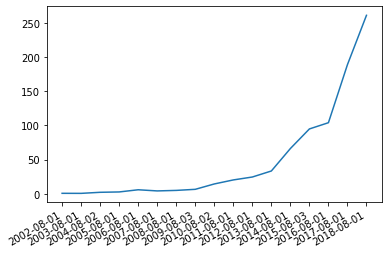

In [24]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

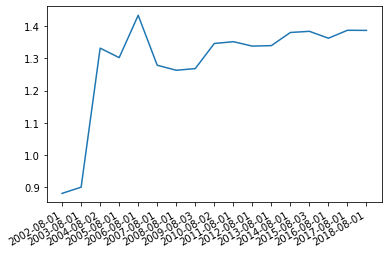

In [25]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [26]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,total,cagr,win_rate,best_corp,worst_corp,best_stock_code,worst_stock_code
0,2002-08-01,2003-08-01,data/daily/8-1/2002-08-01.csv,"[005390, 010600, 008900, 005610, 025880, 01457...",0.881345,"[1.337386018237082, 0.883629191321499, 0.27387...",0.881345,0.881345,0.300000,1.463415,0.273874,027040,008900
1,2003-08-01,2004-08-02,data/daily/8-1/2003-08-01.csv,"[010600, 009460, 014100, 003680, 002900, 02588...",0.920078,"[0.7766666666666666, 0.7991803278688525, 0.743...",0.810906,0.900503,0.333333,1.820455,0.400000,003680,032860
2,2004-08-02,2005-08-01,data/daily/8-1/2004-08-02.csv,"[009270, 010600, 017680, 005320, 032860, 01692...",2.915027,"[2.5, 1.6275071633237823, 1.84375, 1.370786516...",2.363813,1.332103,1.000000,21.000000,1.230366,050050,045060
3,2005-08-01,2006-08-01,data/daily/8-1/2005-08-01.csv,"[010600, 017680, 068290, 008110, 007980, 00532...",1.218332,"[2.0774647887323945, 1.8227513227513228, 0.906...",2.879909,1.302701,0.733333,3.692130,0.117377,014470,014570
4,2006-08-01,2007-08-01,data/daily/8-1/2006-08-01.csv,"[068290, 007980, 025880, 000440, 002720, 01692...",2.105584,"[2.0605187319884726, 2.2964669738863286, 1.916...",6.063889,1.434004,1.000000,4.864407,1.217890,004090,058220
5,2007-08-01,2008-08-01,data/daily/8-1/2007-08-01.csv,"[017680, 065060, 068290, 010600, 006060, 04506...",0.722318,"[0.5676855895196506, 0.12143742255266418, 0.06...",4.380058,1.279126,0.200000,2.281324,0.050625,009470,010600
6,2008-08-01,2009-08-03,data/daily/8-1/2008-08-01.csv,"[016090, 038320, 068290, 011080, 005320, 07852...",1.173353,"[1.3359375, 0.37209302325581395, 1.44911504424...",5.139353,1.263451,0.433333,4.016807,0.229651,078520,005360
7,2009-08-03,2010-08-02,data/daily/8-1/2009-08-03.csv,"[011080, 017680, 010470, 033340, 079650, 00798...",1.305415,"[0.8864864864864865, 1.1645569620253164, 1.704...",6.708988,1.268622,0.733333,3.751515,0.269841,048770,102280
8,2010-08-02,2011-08-01,data/daily/8-1/2010-08-02.csv,"[011080, 033340, 032860, 088790, 011090, 07965...",2.169648,"[0.8785714285714286, 1.2366666666666666, 22.65...",14.556145,1.346565,0.633333,22.653846,0.106838,032860,017680
9,2011-08-01,2012-08-01,data/daily/8-1/2011-08-01.csv,"[011080, 038320, 033340, 044380, 000520, 09144...",1.403691,"[1.6935483870967742, 1.2625698324022345, 1.288...",20.432334,1.352172,0.633333,5.292683,0.768817,031860,000520


In [27]:
# df_account.to_csv('backtest-output/' + DATA_DIR + '.csv', index=False)